In [1]:
import sys
sec_f = 24
from vinyl_srw.srwlib import *
from vinyl_srw.uti_plot import *
from scipy.ndimage.interpolation import zoom
import os
import numpy as np
import pandas as pd
from itertools import islice
from scipy.interpolate import interp1d
from scipy.interpolate import interp2d
from scipy.misc import electrocardiogram
from scipy.signal import find_peaks,peak_widths
import os.path as path
from scipy.interpolate import CubicSpline
import matplotlib.pyplot as plt

In [13]:
#fundamental constants
qe = 1.6021766208e-19
c = 299792458
mu_0 = 4*np.pi*1e-7
eps_0 = 1/(c**2*mu_0)
me = 9.10938356e-31
mp = 1.6726219e-27
h = 6.62607e-34

In [14]:
#**********************Undulator constants:
numPer = 8 #6#Number of ID Periods (without counting for terminations; semi-integer => symmetric vs long. pos.; to allow harmonics to be symmetric or anti-symmetric?)
undPer = 0.055 #0.1106 #Period Length [m]
phBy = 0 #Initial Phase of the Vertical field component
Kund = 1.0 #Kund = qe*By*undPer/(2*np.pi*me*c)
Lund = numPer*undPer#1.7675
By = Kund*(2*np.pi*me*c)/(qe*undPer)#0.1514815555529875


part = SRWLParticle()
part.x = 0.0 #Initial Transverse Coordinates (initial Longitudinal Coordinate will be defined later on) [m]
part.y = 0.0
#part.z = -0.5*(numPer + 4)*undPer #Initial Longitudinal Coordinate (set 2 periods before pickup)
part.z = -0.5*(numPer + 4)*undPer #- 1.3981378
part.xp = 0 #Initial Transverse Velocities
part.yp = 0
part.gamma = 0.100/0.51099890221e-03 #Relative Energy
part.relE0 = 1 #Electron Rest Mass
part.nq = -1 #Electron Charge


npTraj = 20000 #Number of Points for Trajectory calculation
dispBy = array('d', [0]*npTraj)
partTraj = SRWLPrtTrj(_arBy=dispBy) #you can consider it as a part of allocation, values of B field are still zero here
partTraj.partInitCond = part
partTraj.allocate(npTraj, False)
partTraj.ctStart = 0.0 #Start Time for the calculation
#partTraj.ctEnd = fmult*undPer*(numPer+4) #End Time ~1.2166
#partTraj.ctEnd = undPer*(numPer+4)/2+1.3981378+3*zdcent_f
partTraj.ctEnd = undPer*(numPer+4) #+1.#+3*zdcent_f

lmb_0 = undPer/(2*part.gamma**2)*(1 + Kund**2/2.0)

In [15]:
#***********Magnetic Field
sBy = 1 #Symmetry of the Vertical field component vs Longitudinal position
xcID = 0 #Transverse Coordinates of Undulator Center [m]
ycID = 0
zcID = 0 #Longitudinal Coordinate of Undulator Center [m]
und = SRWLMagFldU([SRWLMagFldH(1, 'v', By, phBy, sBy, 1)], undPer, numPer) #Planar Undulator
magFldCnt = SRWLMagFldC([und], array('d', [xcID]), array('d', [ycID]), array('d', [zcID])) #Container of all Field Elements

In [16]:
partTraj = srwl.CalcPartTraj(partTraj, magFldCnt, [1])# why was the last argument 0 and not [1] or something like this

arX = np.asarray(partTraj.arX)
arZ = np.asarray(partTraj.arZ)
arXp = np.asarray(partTraj.arXp)
arZp = np.asarray(partTraj.arZp)

ct_list = np.linspace(partTraj.ctStart, partTraj.ctEnd, partTraj.np)-np.mean((partTraj.ctStart, partTraj.ctEnd))

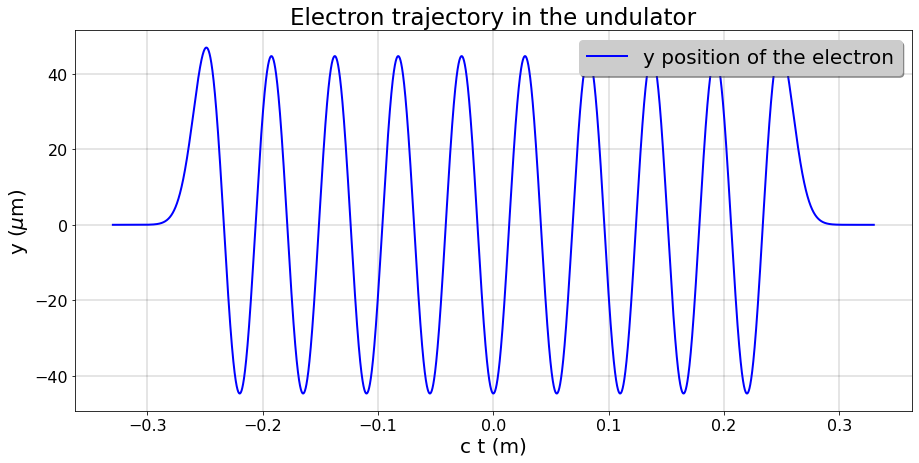

In [17]:
fig,ax = plt.subplots(figsize=[15,7])
plt.plot(ct_list,arX*1e6,linewidth=2,color = 'b',label='y position of the electron')
legend = ax.legend(loc='upper right', shadow=True, fontsize=20, frameon=True)
ax.set_xlabel('c t (m)', fontsize=20)
ax.set_ylabel('y ($\mu$m)', fontsize=20)
plt.title('Electron trajectory in the undulator', fontsize=23)
plt.tick_params(axis='both', which='major', labelsize=16)
#plt.tick_params(axis='both', which='minor', labelsize=16)
ax.grid(color='k', linestyle='-', linewidth=2, alpha=0.1)
frame = legend.get_frame()
frame.set_facecolor('0.8')
for label in legend.get_lines():
       label.set_linewidth(2)  # the legend line width
plt.show()

In [18]:
#***********Electron Beam
f_ring = 7.5e6
Iavg_se = qe*f_ring

elecBeam = SRWLPartBeam()
elecBeam.Iavg = Iavg_se #Average Current [A]
elecBeam.partStatMom1 = part

Iavg_se

1.2016324656000001e-12

In [19]:
n_l = 80
l_min = 0.85
l_max = 1.3
l_list = np.linspace(l_min, l_max, n_l)  # um
x_max = 0.0254  # m
y_max = x_max/np.sqrt(2)  # m
n_x = 512
n_y = int(n_x/np.sqrt(2))

In [20]:
#***********Precision Parameters for SR calculation
meth = 1 #SR calculation method: 0- "manual", 1- "auto-undulator", 2- "auto-wiggler"
relPrec = 0.01 #relative precision
zStartInteg = 0 #longitudinal position to start integration (effective if < zEndInteg)
zEndInteg = 0 #longitudinal position to finish integration (effective if > zStartInteg)
useTermin = 1 #Use "terminating terms" (i.e. asymptotic expansions at zStartInteg and zEndInteg) or not (1 or 0 respectively)
sampFactNxNyForProp = 0 #sampling factor for adjusting nx, ny (effective if > 0)
arPrecPar = [meth, relPrec, zStartInteg, zEndInteg, npTraj, useTermin, sampFactNxNyForProp]
xs = -x_max
xf = x_max
ys = -y_max
yf = y_max
zobs = 3.5
xbins = 2*n_x
ybins = 2*n_y
Ex_3D = np.zeros(shape=(n_l, ybins, xbins), dtype=complex)
Ey_3D = np.zeros(shape=(n_l, ybins, xbins), dtype=complex)

In [21]:
def to_2D(values_1D):
    np_E = np.asarray(values_1D)
    np_E_Real = np_E[::2].reshape((ybins,xbins))
    np_E_Imag = np_E[1::2].reshape((ybins,xbins))
    return np_E_Real+1j*np_E_Imag

In [22]:
from IPython.display import clear_output
for k, l in enumerate(l_list):
    print('Working on {} out of {}'.format(k+1, len(l_list)),' ... ')
    wfr2 = SRWLWfr() #For intensity distribution at fixed photon energy
    wfr2.allocate(1, xbins, ybins) #Numbers of points vs Photon Energy, Horizontal and Vertical Positions
    wfr2.mesh.zStart = zobs #Longitudinal Position [m] at which SR has to be calculated
    wfr2.mesh.xStart = xs #Initial Horizontal Position [m]
    wfr2.mesh.xFin = xf #Final Horizontal Position [m]
    wfr2.mesh.yStart = ys #Initial Vertical Position [m]
    wfr2.mesh.yFin = yf #Final Vertical Position [m]
    wfr2.partBeam = elecBeam
    pe = 1.24/l
    wfr2.mesh.eStart = pe #Initial Photon Energy [eV]
    wfr2.mesh.eFin =  pe #Final Photon Energy [eV]
    srwl.CalcElecFieldSR(wfr2, partTraj, magFldCnt, arPrecPar)
    Ex_3D[k,:,:] = to_2D(wfr2.arEx)
    Ey_3D[k,:,:] = to_2D(wfr2.arEy)
    clear_output(wait=True)
print("Done.")

Done.


In [23]:
dx = (xf-xs)/(xbins-1)
dy = (yf-ys)/(ybins-1)
dl = (l_list[-1]-l_list[0])/(n_l-1)
coef = zobs*np.sqrt(1e9*qe/Iavg_se/l_list)
Ex_3D = coef[:, None, None]*Ex_3D
Ey_3D = coef[:, None, None]*Ey_3D

In [24]:
dx/zobs*dy/zobs*dl*np.sum(np.absolute(Ex_3D)**2)

0.01981092288653931

In [25]:
dx/zobs*dy/zobs*dl*np.sum(np.absolute(Ey_3D)**2)

0.0010714613350851637

In [26]:
dx/zobs*dy/zobs*dl*np.sum(np.absolute(Ex_3D)**2+np.absolute(Ey_3D)**2)

0.020882384221624438

In [27]:
import fur.path_assistant as path_assistant
np.save(path_assistant.srw_Ex_3D_file_path, Ex_3D)
np.save(path_assistant.srw_Ey_3D_file_path, Ey_3D)